<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Peeker-Options" data-toc-modified-id="Peeker-Options-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Peeker Options</a></span><ul class="toc-item"><li><span><a href="#Selecting-Waveforms-to-Display" data-toc-modified-id="Selecting-Waveforms-to-Display-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Selecting Waveforms to Display</a></span></li><li><span><a href="#Spacing-the-Waveforms" data-toc-modified-id="Spacing-the-Waveforms-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Spacing the Waveforms</a></span></li><li><span><a href="#Specifying-a-Time-Window" data-toc-modified-id="Specifying-a-Time-Window-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Specifying a Time Window</a></span></li><li><span><a href="#Showing-Cycle-Times" data-toc-modified-id="Showing-Cycle-Times-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Showing Cycle Times</a></span></li><li><span><a href="#Adding-Titles-and-Captions" data-toc-modified-id="Adding-Titles-and-Captions-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Adding Titles and Captions</a></span></li><li><span><a href="#Setting-the-Display-Size" data-toc-modified-id="Setting-the-Display-Size-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Setting the Display Size</a></span></li><li><span><a href="#Skinning-It" data-toc-modified-id="Skinning-It-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Skinning It</a></span></li><li><span><a href="#Accessing-the-WaveJSON-Data" data-toc-modified-id="Accessing-the-WaveJSON-Data-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Accessing the WaveJSON Data</a></span></li></ul></li></ul></div>

# Peeker Options

Once the simulation has run and all the peekers have gathered their signal traces, you can show the waveforms in various ways.
The options that affect the waveform display will be illustrated using the hierarchical adder example shown below.

In [1]:
from myhdl import *
from myhdlpeek import Peeker

def adder_bit(a, b, c_in, sum_, c_out):
    '''Single bit adder.'''
    @always_comb
    def adder_logic():
        sum_.next = a ^ b ^ c_in
        c_out.next = (a & b) | (a & c_in) | (b & c_in)
    
    # Add some peekers to monitor the inputs and outputs.
    Peeker(a, 'a')
    Peeker(b, 'b')
    Peeker(c_in, 'c_in')
    Peeker(sum_, 'sum')
    Peeker(c_out, 'c_out')
    
    return adder_logic

def adder(a, b, sum_):
    '''Connect single-bit adders to create a complete adder.'''
    c = [Signal(bool(0)) for _ in range(len(a)+1)] # Carry signals between stages.
    s = [Signal(bool(0)) for _ in range(len(a))] # Sum bit for each stage.
    stages = []  # Storage for adder bit instances.
    # Create the adder bits and connect them together.
    for i in range(len(a)):
        stages.append( adder_bit(a=a(i), b=b(i), sum_=s[i], c_in=c[i], c_out=c[i+1]) )
    # Concatenate the sum bits and send them out on the sum_ output.
    @always_comb
    def make_sum():
        sum_.next = ConcatSignal(*reversed(s))
    return instances()  # Return all the adder stage instances.

# Create signals for interfacing to the adder.
a, b, sum_ = [Signal(intbv(0,0,8)) for _ in range(3)]

# Clear-out any existing peeker stuff before instantiating the adder.
Peeker.clear()

# Instantiate the adder.
add_1 = adder(a=a, b=b, sum_=sum_)

# Create some more peekers to monitor the top-level buses.
Peeker(a, 'a_bus')
Peeker(b, 'b_bus')
Peeker(sum_, 'sum_bus')

# Create a testbench generator that applies random inputs to the adder.
from random import randrange
def test(duration):
    for _ in range(duration):
        a.next, b.next = randrange(0, a.max), randrange(0, a.max)
        yield delay(1)

# Simulate the adder, testbench and peekers.
Simulation(add_1, test(8), *Peeker.instances()).run()

<class 'myhdl.StopSimulation'>: No more events


0

## Selecting Waveforms to Display

By default, `to_wavedrom` shows all the captured waveforms. But you can also specify a subset of the waveforms for display:

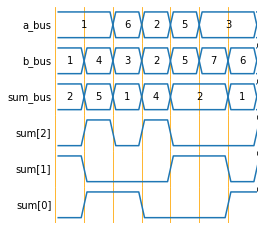

In [2]:
Peeker.show_waveforms('a_bus', 'b_bus', 'sum_bus', 'sum[2]', 'sum[1]', 'sum[0]')

If you don't like typing all those quotation marks, you can place multiple, space-separated peeker names inside a string:

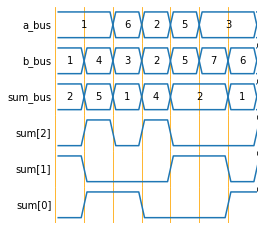

In [3]:
Peeker.show_waveforms('a_bus b_bus sum_bus sum[2] sum[1] sum[0]')

## Spacing the Waveforms

If you want to place some space between the waveforms, just insert a string that doesn't match any peeker's name (I like to use a `|` character for that):

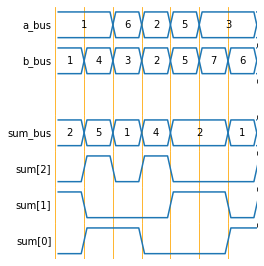

In [4]:
Peeker.show_waveforms('a_bus b_bus | sum_bus sum[2] sum[1] sum[0]')

## Specifying a Time Window

To show only a segment of the waveforms, use the `start_time` and `stop_time` options:

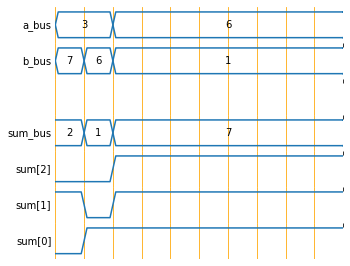

In [5]:
signals = 'a_bus b_bus | sum_bus sum[2] sum[1] sum[0]'
Peeker.show_waveforms(signals, start_time=5, stop_time=15)

## Showing Cycle Times

If it's hard to tell the interval covered by the waveforms, you can turn on the display of cycle times using the `tick` or `tock` options:

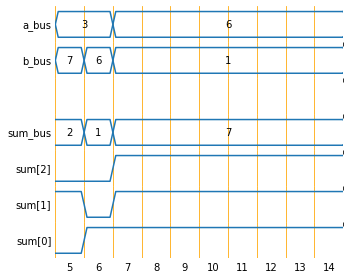

In [6]:
Peeker.show_waveforms(signals, start_time=5, stop_time=15, tock=True)

## Adding Titles and Captions

You can also add a title and caption to your work:

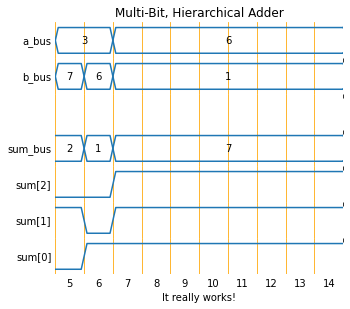

In [7]:
Peeker.show_waveforms(signals, start_time=5, stop_time=15, tock=True,
                   title='Multi-Bit, Hierarchical Adder', caption='It really works!')

## Setting the Display Size

Possibly you have less screen real estate available. The `width` option lets you reduce the entire waveform display:

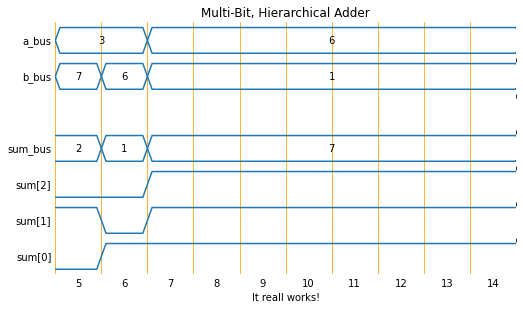

In [8]:
Peeker.show_waveforms(signals, start_time=5, stop_time=15, tock=True,
                   title='Multi-Bit, Hierarchical Adder', caption='It reall works!', width=8)

Sometimes you'll have a long simulation that creates an unreadable display because it's squeezed
into the width of the page. You can restore legibility by setting `width` *wider* than the page
and then using the scroll bars to view the waveforms:

In [9]:
Peeker.clear_traces()
Simulation(add_1, test(100), *Peeker.instances()).run()
Peeker.to_wavedrom(signals, width=4000)
# Peeker.clear_traces()

<class 'myhdl.StopSimulation'>: No more events


## Skinning It

The `skin` option lets you choose the set of graphic elements that are used to draw the waveforms.
Currently, the only allowed values are `default` and `narrow`.

In [10]:
Simulation(add_1, test(8), *Peeker.instances()).run()
Peeker.to_wavedrom(signals, skin='narrow')

<class 'myhdl.StopSimulation'>: No more events


## Accessing the WaveJSON Data

Finally, you might want to get hold of the WaveJSON data directly to get more control over the waveform display. This is done with the `to_wavejson()` method:

In [11]:
wavejson = Peeker.to_wavejson(signals)
wavejson

{'signal': [{'name': 'a_bus',
   'wave': '========',
   'data': ['4', '0', '6', '4', '5', '6', '7', '2']},
  {'name': 'b_bus',
   'wave': '========',
   'data': ['7', '1', '4', '2', '4', '5', '1', '2']},
  {},
  {'name': 'sum_bus',
   'wave': '========',
   'data': ['3', '1', '2', '6', '1', '3', '0', '4']},
  {'name': 'sum[2]', 'wave': '0..10..1'},
  {'name': 'sum[1]', 'wave': '101.010.'},
  {'name': 'sum[0]', 'wave': '1.0.1.0.'}]}

After you manipulate the WaveJSON data, you can display it using the `wavejson_to_wavedrom()` function:

In [12]:
from myhdlpeek import wavejson_to_wavedrom
wavejson_to_wavedrom(wavejson)